# 9: Neural Networks

This notebook uses **scikit‑learn**'s `MLPClassifier` and `MLPRegressor` for a clean, production-grade workflow:
- Pipelines with `StandardScaler`
- Training with early stopping
- Learning curves and validation curves
- Small `GridSearchCV` for hyperparameter tuning


## Setup


In [33]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

# plotting defaults
plt.rcParams["figure.figsize"] = (6,4)
np.set_printoptions(precision=3, suppress=True)
rng = np.random.default_rng(42)



## Part A — Classification on Two Moons
We'll train an `MLPClassifier` inside a `Pipeline` with standardization, visualize the decision boundary, and plot learning & validation curves.


In [34]:
# Generate data
X, y = make_moons(n_samples=1200, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

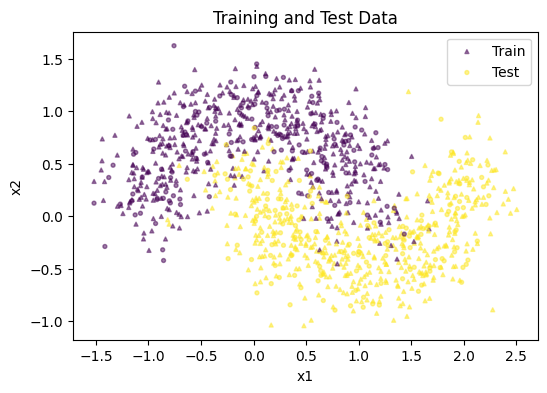

In [35]:
# Plot training and test data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=8, alpha=0.5, label="Train", marker='^')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=8, alpha=0.5, label="Test", marker='o')
plt.title("Training and Test Data")
plt.xlabel("x1"); plt.ylabel("x2")
plt.legend()
plt.show()

In [36]:
# Define pipeline
clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(64,64), activation="relu",
                          solver="adam",
                          alpha=1e-4,  # L2
                          batch_size=128,
                          learning_rate="adaptive",
                          max_iter=400,
                          early_stopping=True,
                          n_iter_no_change=20,
                          random_state=42))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")
print()
print(classification_report(y_test, y_pred))


Test accuracy: 0.937

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       150
           1       0.95      0.92      0.94       150

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



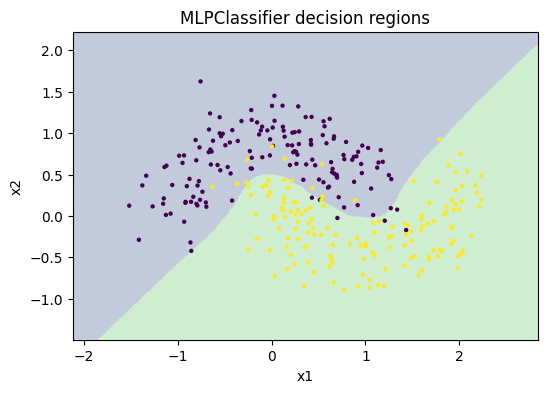

In [37]:

# Decision boundary plot
def plot_decision_regions(clf, X, y, steps=300, padding=0.6):
    x_min, x_max = X[:,0].min()-padding, X[:,0].max()+padding
    y_min, y_max = X[:,1].min()-padding, X[:,1].max()+padding
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps),
                         np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = clf.predict(grid).reshape(xx.shape)
    plt.contourf(xx, yy, zz, alpha=0.3, levels=np.arange(-0.5, 2), antialiased=True)
    plt.scatter(X[:,0], X[:,1], c=y, s=10, edgecolor="none")
    plt.title("MLPClassifier decision regions")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.show()

plot_decision_regions(clf, X_test, y_test)


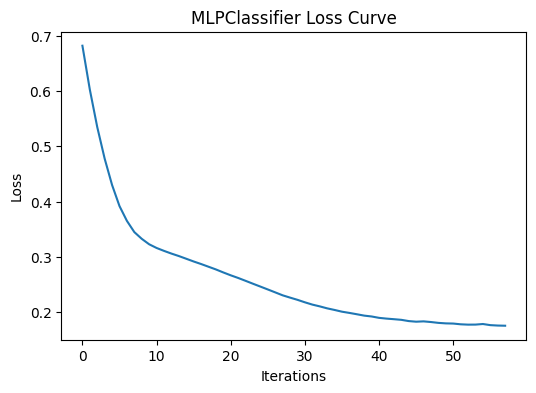

In [38]:
# Plot the loss curve
plt.plot(clf.named_steps['mlp'].loss_curve_)
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [39]:
# Small hyperparameter search
param_grid = {
    "mlp__hidden_layer_sizes": [(64,64), (128,), (128,64)],
    "mlp__alpha": [1e-5, 1e-4, 1e-3],
    "mlp__activation": ["relu", "tanh"]
}

search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=None)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print(f"Best CV accuracy: {search.best_score_:.3f}")

best_clf = search.best_estimator_
test_acc = accuracy_score(y_test, best_clf.predict(X_test))
print(f"Test accuracy (tuned): {test_acc:.3f}")


Best params: {'mlp__activation': 'relu', 'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (128, 64)}
Best CV accuracy: 0.904
Test accuracy (tuned): 0.943



## Part B — Regression on a Sine Wave
We'll fit a noisy sine curve with `MLPRegressor` and examine the fit.


In [40]:
# Create regression data
n = 600
Xs = rng.uniform(-3.0, 3.0, size=(n,1))
ys = np.sin(1.5*Xs) + 0.2*rng.normal(size=(n,1))

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.25, random_state=42)

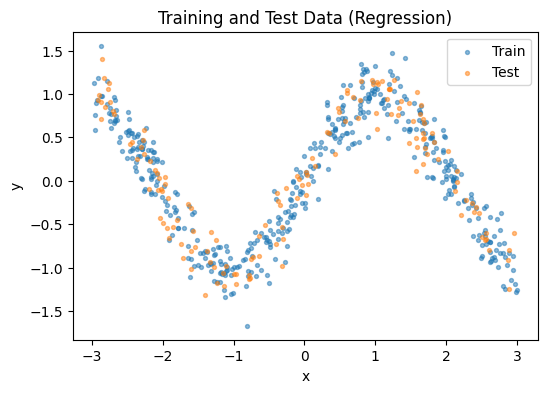

In [41]:
# Plot training and test data for regression
plt.scatter(X_train[:, 0], y_train[:, 0], s=8, alpha=0.5, label="Train")
plt.scatter(X_test[:, 0], y_test[:, 0], s=8, alpha=0.5, label="Test")
plt.title("Training and Test Data (Regression)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [42]:
reg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(64,64),
                         activation="tanh", solver="adam",
                         alpha=1e-4, batch_size=128,
                         learning_rate="adaptive",
                         max_iter=1000, early_stopping=True,
                         n_iter_no_change=20,
                         random_state=7))
])

reg.fit(X_train, y_train.ravel())

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}, R^2: {r2:.3f}")


Test MSE: 0.0462, R^2: 0.912


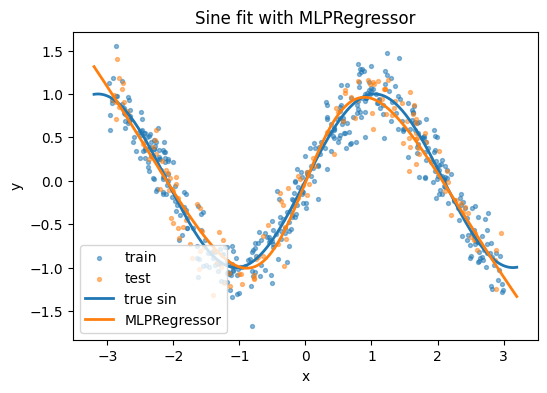

In [43]:
# Plot the learned function
xs = np.linspace(-3.2, 3.2, 400).reshape(-1,1)
ys_true = np.sin(1.5*xs)
ys_hat = reg.predict(xs)

plt.scatter(X_train[:,0], y_train[:,0], s=8, alpha=0.5, label="train")
plt.scatter(X_test[:,0], y_test[:,0], s=8, alpha=0.5, label="test")
plt.plot(xs[:,0], ys_true[:,0], linewidth=2, label="true sin")
plt.plot(xs[:,0], ys_hat, linewidth=2, label="MLPRegressor")
plt.xlabel("x"); plt.ylabel("y")
plt.title("Sine fit with MLPRegressor")
plt.legend()
plt.show()



## Practical tips with scikit‑learn MLPs

- **Always scale features** (e.g., `StandardScaler`), preferably via a `Pipeline`.
- Use **`early_stopping=True`** with a reasonable `n_iter_no_change` to prevent overfitting and save time.
- Try **`relu`** for classification; **`tanh`** can work well in regression with standardized inputs.
- Tune **`alpha`** (L2) to control capacity; watch learning/validation curves.
- For small tabular problems, start with modest widths (e.g., `(64,64)`), then scale up.
- If the solver stalls, increase `max_iter` and consider `learning_rate="adaptive"`.



## Exercises

1. Swap `activation` between `"relu"` and `"tanh"` and compare decision boundaries and test accuracy.
2. Change `hidden_layer_sizes` to `(128,)` and `(128,64)`; examine learning curves.
3. Add `max_fun` or increase `max_iter` to ensure convergence and compare performance.
4. For regression, try `"relu"` activations and compare `R^2` against `"tanh"`.
5. Extend the grid search with `mlp__learning_rate_init` and `mlp__beta_1`, `mlp__beta_2`.
